Retreve data from a storage at The Things Network and plot the main results.

In [1]:
# data management
import requests
import json
import pandas as pd
import numpy as np

In [2]:
# plotting -- add nice date formatter for x-axis
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[date] = converter
munits.registry[datetime] = converter

Now, it is time to get the actual data. We need to do a HTTP request, and to be authorized to do so.

In [3]:
# name of the app on TTN
app = 'lsn50-tiller-1'

# we have four temperature sensors at Tiller
devices = ['t1001', 't1002', 't1003', 't1004']

# authorization key (should have been hidden, but this is just for reading, so, well, let's say it's ok, this time!)
akey = 'NNSXS.AOGB6S3PX74H4DUOJZ4AYVCHCPFF5HJGVIOC76A.C4K7SJKY67K3J5XB7KETKCFVPQJQN4JXGEDX5OW5HXA6ICZTSS5A'

In [4]:
# URL for requesting all data
url = f'https://eu1.cloud.thethings.network/api/v3/as/applications/{app}/packages/storage/'

# how to get data from just one unit, in this case, the first
url0 = f'https://eu1.cloud.thethings.network/api/v3/as/applications/{app}/devices/{devices[0]}/packages/storage/'

# headers, for the http GET request
headers = {
    'Accept': 'text/event-stream', 
    'Authorization': f'Bearer {akey}',
}
params =  {
    # 'after': '2021-09-21T00:00:00Z',  # just receive after this
    # 'field_mask': 'up.uplink_message.decoded_payload',  # just receive this info
}

In [5]:
# let's make the actual request, and hope for response code 200 -- OK!
r = requests.get(url, headers=headers, params=params)
r

<Response [200]>

The data is stored/retrieved in 'r.text' as a list of json-objects. Let us now load this as more manageable data.

In [6]:
def parse_response(r):
    # parse the response and return a list of json-loads-objects (dicts)
    # we filter out lines that have no info, and then those with no decoded payload
    out = [json.loads(line) for line in r.text.splitlines() if len(line)]
    out = [item for item in out if 'decoded_payload' in item['result']['uplink_message']]
    return out

In [7]:
# let's parse the results, and see if we get something meaningful
p = parse_response(r)
# print(p[0])  # uncomment this to see the datastructure!
print(p[0]['result']['end_device_ids']['device_id'])
print(len(p))

t1004
2619


Json-dicts are neat for look up of individual data, but not so nice for direct plotting. Let's define some functions to filter out data and make us some lists, that are easier to handle. We take one data point from each json object in the list 'p'.

In [8]:
def p2devID(p):
    # return the device id for each item 
    # p = parse_response(r)
    return [item['result']['end_device_ids']['device_id'] for item in p]

def p2payload(p):
    # return the decoded payload for each item 
    return [item['result']['uplink_message']['decoded_payload'] for item in p]
    
def p2rssi(p, datano=0):
    # return the signal strength for each item 
    return [item['result']['uplink_message']['rx_metadata'][datano]['rssi'] for item in p]
        
def p2time(p):
    # return the received time for each item 
    return [pd.to_datetime(item['result']['received_at']) for item in p]

In [9]:
# we can now test the functions, to see if the results are satisfactory
print(p2devID(p)[0])
print(p2payload(p)[0])
print(p2rssi(p)[0])
print(p2time(p)[0])

print('Are all of equal lenght?')  # using funky python chaning of operators here! :D
print(len(p2devID(p)) == len(p2payload(p)) == len(p2rssi(p)) == len(p2time(p)))

t1004
{'ADC_CH0V': 0.316, 'BatV': 3.362, 'Digital_IStatus': 'L', 'Door_status': 'OPEN', 'EXTI_Trigger': 'FALSE', 'Hum_SHT': 6553.5, 'TempC1': 9.9, 'TempC_SHT': -0.1, 'Work_mode': 'IIC'}
-106
2021-09-19 00:01:06.660309702+00:00
Are all of equal lenght?
True


Now that we can easily make lists, we can easily make a dataframe, which enables easier manipulation of data!

In [10]:
pl = p2payload(p)
df = pd.DataFrame({
    'devID': p2devID(p),
    'payload': pl,
    'TempC1': [i['TempC1'] for i in pl],
    'BatV': [i['BatV'] for i in pl],
    'rssi': p2rssi(p),
    'time': p2time(p),
})
df['time'] = pd.to_datetime(df['time'])  # need to be explicit about this, for the plotter to understand later
df = df.set_index('time')  # having the date as inxed enables us to plot a series, without passing this explicitly

In [11]:
# this is how our dataframe now looks
df

,devID,payload,TempC1,BatV,rssi
time,,,,,
2021-09-19 00:01:06.660309702+00:00,t1004,"{'ADC_CH0V': 0.316, 'BatV': 3.362, 'Digital_IS...",9.9,3.362,-106
2021-09-19 00:04:16.671196216+00:00,t1003,"{'ADC_CH0V': 0.277, 'BatV': 3.364, 'Digital_IS...",9.8,3.364,-113
2021-09-19 00:04:54.426066721+00:00,t1001,"{'ADC_CH0V': 0.293, 'BatV': 3.358, 'Digital_IS...",9.8,3.358,-108
2021-09-19 00:04:59.754879934+00:00,t1002,"{'ADC_CH0V': 0.299, 'BatV': 3.356, 'Digital_IS...",9.8,3.356,-106
2021-09-19 00:06:06.613667564+00:00,t1004,"{'ADC_CH0V': 0.315, 'BatV': 3.362, 'Digital_IS...",9.9,3.362,-109
...,...,...,...,...,...
2021-09-21 08:31:08.378040676+00:00,t1004,"{'ADC_CH0V': 0.311, 'BatV': 3.36, 'Digital_ISt...",9.0,3.360,-113
2021-09-21 08:34:19.760151132+00:00,t1003,"{'ADC_CH0V': 0.274, 'BatV': 3.359, 'Digital_IS...",9.0,3.359,-111
2021-09-21 08:35:07.060951551+00:00,t1002,"{'ADC_CH0V': 0.298, 'BatV': 3.356, 'Digital_IS...",9.0,3.356,-112


So far, so good! We have asked for, received, parsed, filtered, and kneaded our data into a nice format. This was all done to facilitate plotting of the data. We will inspect the **temperature**, which was the main point, but also look at **signal strength** and **battery voltage**.

In [12]:
def plotter(what='TempC1', ylabel=None, left='2021-01-01', right=None):
    # create a plot from the data in df
    dfp = df.copy()
    
    if left is not None:  # define where the plotting starts
        left = pd.Timestamp(left, tz="Europe/Brussels")
        dfp = df.loc[df.index > left]
    if right is not None:  # define where the plotting ends
        right = pd.Timestamp(right, tz="Europe/Brussels")
        dfp = df.loc[df.index < right]

    plt.figure(dpi=200)  # use 400 dpi to get a larger figure
    for devID in sorted(set(dfp['devID'])):              # reduce the list of devID to a set, and sort it
        data = dfp.loc[dfp['devID'] == devID][what]  # filter data for a given dev ID
        plt.plot(data, label=devID)  # plot line with correct label
    plt.legend()
    plt.ylabel(ylabel)

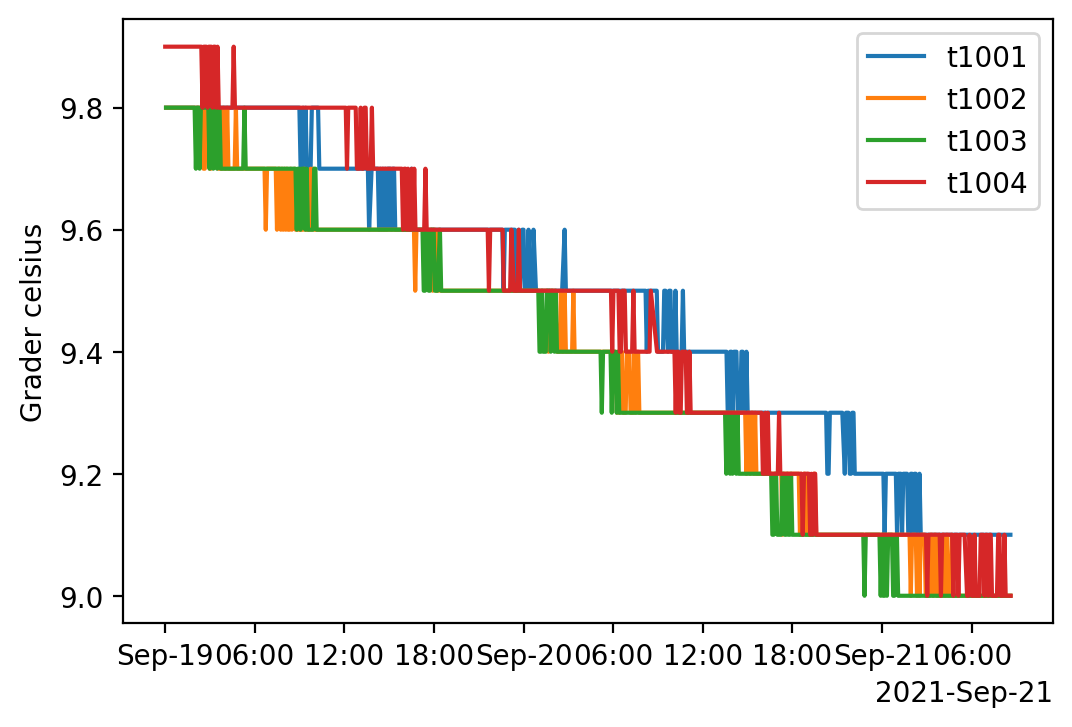

In [13]:
plotter(what='TempC1', ylabel='Grader celsius')

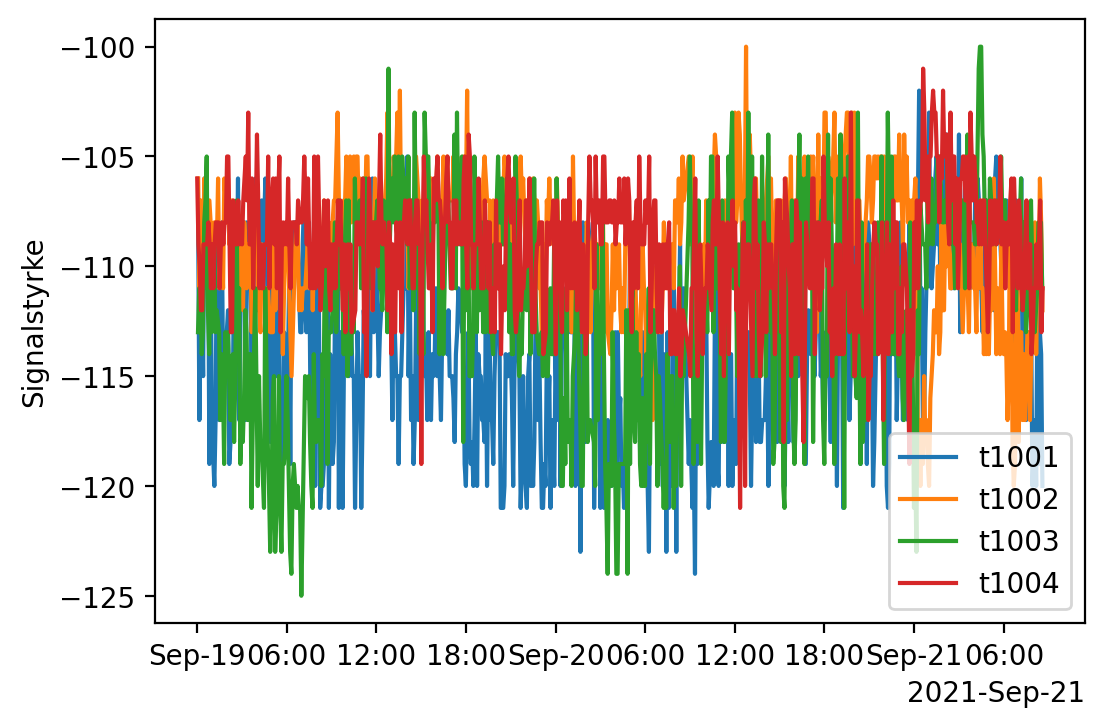

In [14]:
plotter(what='rssi', ylabel='Signalstyrke')

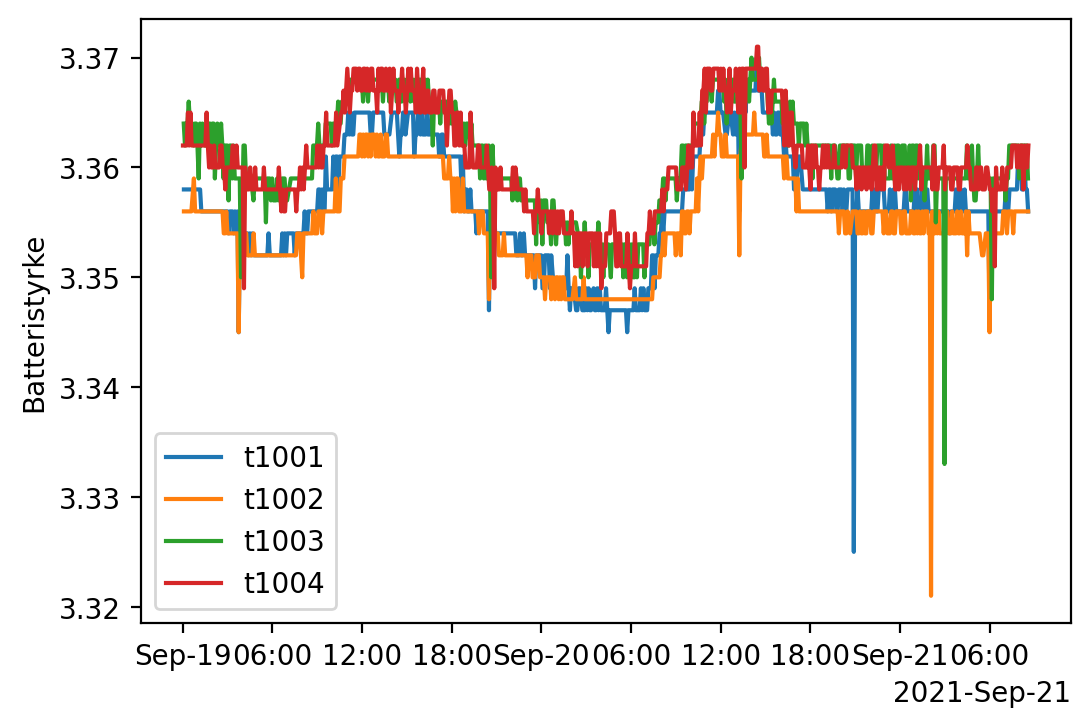

In [15]:
plotter(what='BatV', ylabel='Batteristyrke')

... and that was that!